<a href="https://colab.research.google.com/github/udayameister/CST-GNN/blob/main/dwi_preprocess_AAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nibabel dipy nilearn networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 117.7 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 4.0.2
    Uninstalling nibabel-4.0.2:
      Successfully uninstalled nibabel-4.0.2


In [12]:
!pip install nibabel

In [13]:
import numpy as np
from dipy.io.image import load_nifti
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel, fractional_anisotropy
from dipy.tracking.utils import seeds_from_mask
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.tracking.streamline import Streamlines
from nilearn.image import resample_to_img
from nilearn.input_data import NiftiLabelsMasker
import matplotlib.pyplot as plt
import nibabel as nib

In [14]:

# Define file paths
dwi_pa_path = '/content/sub-CON02_ses-preop_acq-PA_dwi.nii.gz'
dwi_ap_path = '/content/sub-CON02_ses-preop_acq-AP_dwi.nii.gz'
bval_pa_path = '/content/sub-CON02_ses-preop_acq-PA_dwi.bval'
bvec_pa_path = '/content/sub-CON02_ses-preop_acq-PA_dwi.bvec'
bval_ap_path = '/content/sub-CON02_ses-preop_acq-AP_dwi.bval'
bvec_ap_path = '/content/sub-CON02_ses-preop_acq-AP_dwi.bvec'
aal_atlas_path = '/content/AAL.nii.gz'

In [15]:
# Load the DWI PA and AP data
data_pa, affine_pa = load_nifti(dwi_pa_path)
data_ap, affine_ap = load_nifti(dwi_ap_path)

In [16]:
# Load b-values and b-vectors
bvals_pa = np.loadtxt(bval_pa_path)
bvecs_pa = np.loadtxt(bvec_pa_path)
bvals_ap = np.loadtxt(bval_ap_path)
bvecs_ap = np.loadtxt(bvec_ap_path)

In [17]:
# Concatenate PA and AP data
data = np.concatenate((data_pa, data_ap), axis=-1)
affine = affine_pa  # Assuming affine matrices are the same

In [18]:
# Concatenate b-values and b-vectors
bvals = np.concatenate((bvals_pa, bvals_ap))
bvecs = np.concatenate((bvecs_pa, bvecs_ap), axis=1)

In [19]:
# Load AAL atlas and resample to DWI image space
aal_atlas = nib.load(aal_atlas_path)
aal_resampled = resample_to_img(aal_atlas, nib.Nifti1Image(data[..., 0], affine))

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int16 to float32
  return resample_img(


In [20]:
# Create gradient table
gtab = gradient_table(bvals, bvecs.T)

In [21]:
# Apply median Otsu mask for brain extraction
from dipy.segment.mask import median_otsu
maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=4, numpass=2)

In [22]:
# Apply local PCA denoising
from dipy.denoise.localpca import localpca
denoised_data = localpca(maskdata, sigma=1)

In [23]:
# Fit the tensor model
tensor_model = TensorModel(gtab)
tensor_fit = tensor_model.fit(denoised_data)

In [24]:
# Calculate fractional anisotropy (FA)
fa = fractional_anisotropy(tensor_fit.evals)
fa[np.isnan(fa)] = 0

In [25]:
# Define stopping criterion
stopping_criterion = ThresholdStoppingCriterion(fa, 0.2)

In [26]:
# Generate seeds for tractography
seeds = seeds_from_mask(mask, affine, density=2)

In [27]:
# Perform fiber tracking
tensor_peaks = peaks_from_model(tensor_model, denoised_data, default_sphere, relative_peak_threshold=0.5, min_separation_angle=25)
streamline_generator = LocalTracking(tensor_peaks, stopping_criterion, seeds, affine, step_size=0.5)
streamlines = Streamlines(streamline_generator)

In [28]:
# Save streamlines (optional)
nib.streamlines.save(streamlines, 'streamlines.trk')

/usr/local/lib/python3.10/dist-packages/nibabel/streamlines/__init__.py:131: ExtensionWarning: The extension you specified is unusual for the provided 'TractogramFile' object.
  warnings.warn(msg, ExtensionWarning)


In [29]:
# Extract time series for AAL regions
masker = NiftiLabelsMasker(labels_img=aal_resampled, standardize=True)
time_series = masker.fit_transform(nib.Nifti1Image(data[..., 0], affine))

/usr/local/lib/python3.10/dist-packages/nilearn/signal.py:74: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn(


In [30]:
# Construct the connectome matrix
n_regions = 90
connectome_matrix = np.zeros((n_regions, n_regions))

In [35]:
for streamline in streamlines:
    streamline_coords = np.round(streamline).astype(int)
    nodes = []
    for coord in streamline_coords:
        # Ensure coordinates are within bounds
        if np.all(coord >= 0) and np.all(coord < aal_resampled.shape):
            label = aal_resampled.get_fdata()[tuple(coord)]
            # Check if label is within valid range and handle invalid labels
            if 0 < label <= n_regions:
                # Convert the label to an integer and subtract 1 for zero-based indexing
                nodes.append(int(label - 1))

    for i, node in enumerate(nodes[:-1]):
        next_node = nodes[i + 1]
        if node != next_node:
            connectome_matrix[node, next_node] += 1
            connectome_matrix[next_node, node] += 1

In [36]:
# Normalize the connectivity matrix
connectome_matrix /= connectome_matrix.sum(axis=1, keepdims=True)

In [37]:
# Save the connectivity matrix
np.save('connectome_matrix.npy', connectome_matrix)

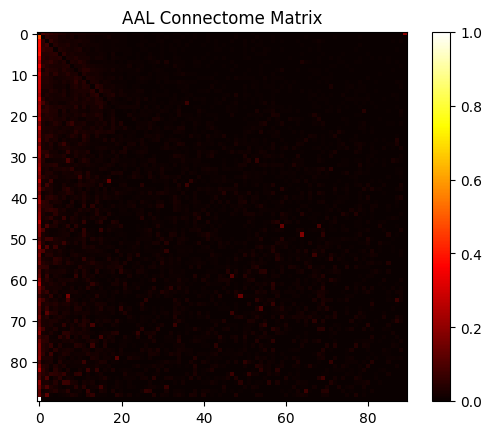

In [38]:
# Visualize the connectivity matrix
plt.imshow(connectome_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('AAL Connectome Matrix')
plt.show()

In [39]:
print("DWI preprocessing and connectome matrix construction complete.")

DWI preprocessing and connectome matrix construction complete.
